In [1]:
import os
import torch
# torch.multiprocessing.set_start_method("spawn")
import numpy as np
import cv2

from torch.utils import data
from torchvision import transforms

import time
import matplotlib.pyplot as plt
import random
import numbers
import math
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import h5py
import importlib
import opencv_transforms as cv_transforms
import warnings

In [2]:
def plot_times_and_normalized(cv_times, pil_times, img_sizes,transform_name, should_save=False, savedir=None):
    normalized_cv = cv_times /cv_times.mean(axis=0)
    normalized_pil = pil_times / cv_times.mean(axis=0)
    
    sizes = [str(i) for i in img_sizes]
    
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    x = np.arange(0, cv_times.shape[1])
    
    ax[0].errorbar(x, cv_times.mean(axis=0), yerr=cv_times.std(axis=0), fmt='o-', label='OpenCV')
    ax[0].errorbar(x, pil_times.mean(axis=0), yerr=pil_times.std(axis=0), fmt='o-', label='PIL')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(sizes, rotation=45)
    ax[0].set_xlabel('Image sizes')
    ax[0].set_ylabel('Execution time (ms)')
    ax[0].legend()
    
    ax[1].errorbar(x, normalized_cv.mean(axis=0), yerr=normalized_cv.std(axis=0), 
                   fmt='o-', label='OpenCV')
    ax[1].errorbar(x, normalized_pil.mean(axis=0), yerr=normalized_pil.std(axis=0), 
                   fmt='o-', label='PIL')
    
    y = normalized_pil.mean(axis=0)
    [ax[1].text(x[i]+0.05, y[i]+0.05, '%0.2f'%(t)) for i,t in enumerate(y)]
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(sizes, rotation=45)
    ax[1].set_xlabel('Image sizes')
    ax[1].set_ylabel('Execution time normalized to OpenCV')
    
    fig.suptitle('Transform: %s' %(transform_name), fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    if should_save and savedir is not None:
        figname = 'benchmarking_%s.png' %(transform_name)
        savename = os.path.join(savedir, figname)
        fig.savefig(savename)

# TESTING!!

In [3]:
importlib.reload(cv_transforms)

<module 'opencv_transforms' from 'C:\\Users\\jpb\\Documents\\python\\dataloader_benchmarks\\opencv_transforms.py'>

In [4]:
plt.style.use('ggplot')

cityscapes_dir = r'E:\DATA\semantic_segmentation\Cityscapes'
fname = os.path.join(cityscapes_dir, 'train.h5')

img_sizes = [(2048, 1024), (1024, 512), (512,256), (256, 128), (128, 64)]
n_repeats = 100 # must be less than dataset size

In [9]:
transform_pil = transforms.Compose([transforms.Resize(size=(512,256)),
                                   transforms.RandomHorizontalFlip(p=0.5), 
                                   transforms.ColorJitter(brightness=0.5,
                                                         contrast=0.25),
                                   transforms.RandomRotation(degrees=10)])
transform_cv = cv_transforms.Compose([cv_transforms.Resize(size=(512,256)),
                                   cv_transforms.RandomHorizontalFlip(p=0.5), 
                                   cv_transforms.ColorJitter(brightness=0.5,
                                                         contrast=0.25),
                                   cv_transforms.RandomRotation(degrees=10)])

transform_name = 'Resize flip brightness contrast rotate'

In [10]:
pil_times = np.zeros((n_repeats, len(img_sizes)), dtype=np.float64)
cv_times = np.zeros((n_repeats, len(img_sizes)), dtype=np.float64)

with h5py.File(fname, 'r') as f:
    for i in tqdm(range(len(img_sizes))):
        img_size = img_sizes[i]
        resize_pil = transforms.Resize((img_size[0], img_size[1]))
        resize_cv = cv_transforms.Resize((img_size[0], img_size[1]))
        
        # args = {'size': (img_size[0]//2, img_size[1]//2)}
        # this_transform_pil = transform_pil(**args)
        # this_transform_cv = transform_cv(**args)
        this_transform_pil = transform_pil
        this_transform_cv = transform_cv
        for j in tqdm(range(n_repeats)):
            
            img = f['images'][j]
            img_pil = Image.fromarray(img)
            img = resize_cv(img)
            img_pil = resize_pil(img_pil)
            
            t0 = time.clock()
            out_pil = this_transform_pil(img_pil)
            t2 = (time.clock()-t0)*1000 # milliseconds
            pil_times[j,i]= t2
            
            t0 = time.clock()
            out_cv = this_transform_cv(img)
            t2 = (time.clock()-t0)*1000 # milliseconds
            cv_times[j,i]= t2

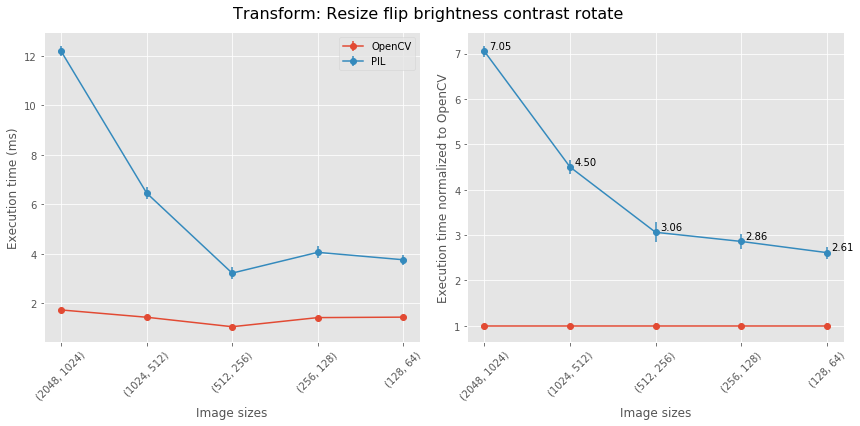

In [11]:
savedir = r'D:\Analysis\cv_transforms'
plot_times_and_normalized(cv_times, pil_times, img_sizes, transform_name, 
                         should_save=True, savedir=savedir)